# Table of contents
### A. Before preprocessing (Run with outliers)
### B. Preprocessing
    1. Price (Remove Outliers)
    2. Latitude (Remove Outliers)
    3. Longitude (Remove Outliers)
    4. Bedrooms (Remove Outliers)
    5. Bathrooms (Remove Outliers)
        Special. Balance the classes (Match the number rows for each Low, Medium, and High)
    6. Features (TF-IDF)
    7. Append 'Features' as a single value
    8. Append the distance from Manhattan (For Bonus)
### C. Cross-validation and train_test_split

# Import Libraries and Data

In [1]:
import seaborn as sns
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import math
import nltk as nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.draw.dispersion import dispersion_plot
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score


clf = SVC(gamma=10, probability=True)
le = preprocessing.LabelEncoder()
#running only 5000 data points because SVM takes to long to train O(features * rows^2)
INDEX = 8000 
pd.set_option('display.max_rows', None)
df = pd.read_json('./train.json')
df = df[INDEX:INDEX + 10000]
new_df = df.drop(['description', 'building_id', 'manager_id', 'created', 'display_address', 'listing_id', 'street_address', 'photos'], axis=1)
new_df.head()

,bathrooms,bedrooms,features,latitude,longitude,price,interest_level
20230,2.0,2,"[Private Outdoor Space, Exclusive, Huge Privat...",40.7284,-73.9858,4200,high
20232,1.0,1,"[Pre-War, Dogs Allowed, Cats Allowed]",40.7275,-74.0019,4199,low
20234,1.0,3,"[Doorman, Elevator, Dishwasher, No Fee]",40.7556,-73.9668,4495,low
20237,1.0,1,"[Cats Allowed, Dogs Allowed, HARDWOOD FLOORS, ...",40.6721,-73.9720,2750,medium
20239,1.0,1,"[Cats Allowed, Dogs Allowed]",40.8404,-73.9375,1600,medium


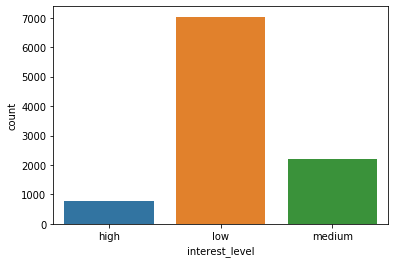

In [2]:
_ = sns.countplot(new_df['interest_level'])

# A. Before preprocessing (Run with outliers)

In [3]:
df0 = new_df.drop(['features','interest_level'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(df0, new_df['interest_level'], test_size=0.40, random_state=0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
scores = cross_val_score(clf, X_train, y_train, cv=5)
#print("Train: ", scores)
print("Train: " + str(np.mean(scores)))

clf.fit(X_train, y_train)

# Predict labels on the test data using the trained classifier.
predictions = clf.predict(X_test)

# Calculate the F1 score by comparing predicted and actual labels.
F1 = f1_score(y_test, predictions, average='weighted')

# calculate log loss
y_prob = clf.predict_proba(X_test) 
logloss = log_loss(y_test, y_prob)

print("F1 score: " + str(F1))
print("Log loss: " + str(logloss))

print("Before preprocessing: ", clf.score(X_test, y_test))

le.fit(predictions)
print(le.classes_)


(6000, 5) (6000,)
(4000, 5) (4000,)
Train: 0.6858303309006928
F1 score: 0.6189667100407578
Log loss: 0.7605215008582953
Before preprocessing:  0.6885
['high' 'low' 'medium']


# B. Preprocessing

# 1. Price Attribute
### Remove outliers (result in df1)

In [4]:
df_price = new_df['price']  
IQR = df_price.quantile(0.75)-df_price.quantile(0.25)
upper = df_price.quantile(0.75)+IQR*1.5
lower = df_price.quantile(0.25)-IQR*1.5

print ("Outliers lie outside the upper and lower limits represented by the ends of the whiskers.")
print("The upper and lower limits are: ", upper," and ", lower ,", respectively.")
print("(Calculated using Interquantile Range Rule: 75% quantile + 1.5*IQR and 25% quantile - IQR*1.5)")

df1 = new_df[(new_df['price'] <upper) & (new_df['price'] >lower)]
df1.head()

Outliers lie outside the upper and lower limits represented by the ends of the whiskers.
The upper and lower limits are:  6500.0  and  100.0 , respectively.
(Calculated using Interquantile Range Rule: 75% quantile + 1.5*IQR and 25% quantile - IQR*1.5)


,bathrooms,bedrooms,features,latitude,longitude,price,interest_level
20230,2.0,2,"[Private Outdoor Space, Exclusive, Huge Privat...",40.7284,-73.9858,4200,high
20232,1.0,1,"[Pre-War, Dogs Allowed, Cats Allowed]",40.7275,-74.0019,4199,low
20234,1.0,3,"[Doorman, Elevator, Dishwasher, No Fee]",40.7556,-73.9668,4495,low
20237,1.0,1,"[Cats Allowed, Dogs Allowed, HARDWOOD FLOORS, ...",40.6721,-73.9720,2750,medium
20239,1.0,1,"[Cats Allowed, Dogs Allowed]",40.8404,-73.9375,1600,medium


# 2. Latitude Attribute
### Remove outliers (result in df2)

In [5]:
df_lat = df1['latitude']

IQR = df_lat.quantile(0.75)-df_lat.quantile(0.25)
upper = df_lat.quantile(0.75)+IQR*1.5
lower = df_lat.quantile(0.25)-IQR*1.5

print("The upper and lower limits are: ", upper," and ", lower ,", respectively.")
df2 = df1[(df1['latitude']<upper) & (df1['latitude']>lower)]
df2.describe()

The upper and lower limits are:  40.845200000000006  and  40.65719999999999 , respectively.


,bathrooms,bedrooms,latitude,longitude,price
count,9054.000000,9054.000000,9054.000000,9054.000000,9054.000000
mean,1.138281,1.468854,40.751002,-73.972721,3315.577977
std,0.366930,1.051040,0.034638,0.028249,1091.182049
min,0.000000,0.000000,40.657400,-74.045400,1100.000000
25%,1.000000,1.000000,40.728525,-73.991700,2500.000000
50%,1.000000,1.000000,40.751600,-73.977900,3100.000000
75%,1.000000,2.000000,40.773900,-73.955025,3900.000000
max,4.000000,6.000000,40.845200,-73.754600,6495.000000


# 3. Longitude Attribute
### Remove outliers (result in df3)

In [6]:
df_long = df2['longitude']
 
IQR = df_long.quantile(0.75)-df_long.quantile(0.25)
upper = df_long.quantile(0.75)+IQR*1.5
lower = df_long.quantile(0.25)-IQR*1.5

print("The upper and lower limits are: ", upper,"and", lower ,", respectively.") 
#print("The total number of records before removing the outliers is", before,".")
df3 = df2[(df2['longitude'] >lower) & (df2['longitude']<upper)]
df3.describe()

The upper and lower limits are:  -73.90001250000003 and -74.04671249999998 , respectively.


,bathrooms,bedrooms,latitude,longitude,price
count,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000
mean,1.138073,1.470449,40.751357,-73.975067,3339.585613
std,0.367245,1.053884,0.034717,0.022569,1084.987169
min,0.000000,0.000000,40.657400,-74.045400,1100.000000
25%,1.000000,1.000000,40.729050,-73.992000,2500.000000
50%,1.000000,1.000000,40.752000,-73.978400,3150.000000
75%,1.000000,2.000000,40.774250,-73.956300,3950.000000
max,4.000000,6.000000,40.845200,-73.902600,6495.000000


# 4. Bedrooms Attribute
### Remove outliers (result in df4)

In [7]:
df_bedrooms = df3['bedrooms']
 
IQR = df_bedrooms.quantile(0.75)-df_bedrooms.quantile(0.25)
upper = df_bedrooms.quantile(0.75)+IQR*1.5
lower = max(df_bedrooms.quantile(0.25)-IQR*1.5, 0)

print("The upper and lower limits are: ", upper,"and", lower ,", respectively.") 
#print("The total number of records before removing the outliers is", before,".")
#print("Min: ",min(df_bedrooms) , " Max: ", max(df_bedrooms))
df4 = df3[(df3['bedrooms'] >= lower) & (df3['bedrooms'] <= upper)]
df4.describe()

The upper and lower limits are:  3.5 and 0 , respectively.


,bathrooms,bedrooms,latitude,longitude,price
count,8619.000000,8619.000000,8619.000000,8619.000000,8619.000000
mean,1.120026,1.390881,40.751264,-73.975345,3288.069730
std,0.344382,0.964087,0.034417,0.022493,1044.530078
min,0.000000,0.000000,40.657400,-74.045400,1100.000000
25%,1.000000,1.000000,40.729150,-73.992250,2500.000000
50%,1.000000,1.000000,40.752000,-73.978700,3100.000000
75%,1.000000,2.000000,40.773900,-73.956400,3850.000000
max,3.000000,3.000000,40.845200,-73.902600,6495.000000


# 5. Bathrooms Attribute
### Remove outliers (result in df5)

In [8]:
df_bathrooms = df4['bathrooms']
 
IQR = df_bathrooms.quantile(0.75)-df_bathrooms.quantile(0.25)

upper = math.ceil(df_bathrooms.quantile(0.75)+IQR*1.5)
lower = max(df_bathrooms.quantile(0.25)-IQR*1.5, 0)
average = sum(df_bathrooms) / len(df_bathrooms)
  
print("The upper and lower limits are: ", upper,"and", lower ,", respectively.") 
#print("The total number of records before removing the outliers is", before,".") 

df5 = df4[(df4['bathrooms'] >= lower) & (df4['bathrooms'] <= upper)]
df5.describe()

The upper and lower limits are:  1 and 1.0 , respectively.


,bathrooms,bedrooms,latitude,longitude,price
count,7454.0,7454.000000,7454.000000,7454.000000,7454.000000
mean,1.0,1.245103,40.751375,-73.975270,3078.788436
std,0.0,0.916272,0.034736,0.022551,867.929956
min,1.0,0.000000,40.657400,-74.033900,1200.000000
25%,1.0,1.000000,40.728800,-73.992400,2451.750000
50%,1.0,1.000000,40.752000,-73.978750,2960.000000
75%,1.0,2.000000,40.773900,-73.956300,3584.750000
max,1.0,3.000000,40.845200,-73.902600,6450.000000


# Special. Balance the classes
### Match the number rows for each Low, Medium, and High (result in df_s)

In [9]:
# # Class count
# count_class_0, count_class_1, count_class_2 = df5['interest_level'].value_counts()

# # Divide by class
# df_class_0 = df5[new_df['interest_level'] == 'low']
# df_class_1 = df5[new_df['interest_level'] == 'medium']
# df_class_2 = df5[new_df['interest_level'] == 'high']

# df_class_0_under = df_class_0.sample(count_class_2)
# df_class_1_under = df_class_1.sample(count_class_2)
# df_s = pd.concat([df_class_0_under, df_class_1_under, df_class_2], axis=0)

# print('Random under-sampling:')
# print(df_s['interest_level'].value_counts())
# _ = sns.countplot(df_s['interest_level'])

# 6. Features Attribute
### TF-IDF (df6 holds only features)

In [10]:
df5.reset_index(drop=True, inplace=True)

# df_s.reset_index(drop=True, inplace=True)

stopWords = stopwords.words('english')
add_words = [".", "..", "...", ",", "/", "/lndry", ":", "b","’", "•", "this",
             "l", "&", "*", "ss", "in","**", "***", "!","!!","!!!","!!!!", "w/", "(", ")", 
             "'s", "$", "'", "..", "01", "01 16","04", "05", "05 01", "06", "05 01 16", "0862", "in"]
stopWords.extend(add_words)


# features = df_s['features']
features = df5['features']

wordSetRow = []
for words in features:
    wordsForRows = ""
    for word in words:
        if word.lower() not in stopWords:
            if(wordsForRows == ""):
                wordsForRows = word.lower()
            else:
                wordsForRows = wordsForRows + " " + word.lower()
                
    wordSetRow.append(wordsForRows)

cv=TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1,2))
x_traincv = cv.fit_transform(wordSetRow)
new_features = pd.DataFrame(
    x_traincv.todense(),
    columns=cv.get_feature_names(),
)
df6 = pd.concat([df5.interest_level, new_features], axis=1, sort=False)

# df6 = pd.concat([df_s.interest_level, new_features], axis=1, sort=False)
df6.head(10)

,interest_level,1br,1br home,24,24 concierge,24 doorman,24 hr,2br,2br home,2br super,...,wifi access,windows,windows galore,with,with breathtaking,with private,with rentable,work,yoga,yoga dance
0,low,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,low,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,medium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,medium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,low,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,low,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,medium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,low,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,low,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,low,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 7. Append Features as a single value
### (Result in df7)

In [11]:
new_df6 = df6.drop(['interest_level'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(new_df6, df6['interest_level'], test_size=0.40, random_state=0, stratify=df6['interest_level'])

clf.fit(X_train, y_train)
clf_predict = clf.predict(new_df6)
le.fit(clf_predict)
print(le.classes_)

df5 = df5.drop(['features'], axis=1)
df5['clf_predict'] = le.transform(clf_predict)
df7 = df5

# df_s = df_s.drop(['features'], axis=1)
# df_s['clf_predict'] = le.transform(clf_predict)
# df7 = df_s

['high' 'low' 'medium']


### Cross-validation and train_test_split (Before Mall added)

In [12]:
new_df7 = df7.drop(['interest_level'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(new_df7, df7['interest_level'], test_size=0.50, random_state=0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

clf = SVC(gamma=15, probability=True, kernel='rbf')

scores = cross_val_score(clf, X_train, y_train, cv=5)
print("Before the mall Train: "+ str(np.mean(scores)))
clf.fit(X_train, y_train)


# Predict labels on the test data using the trained classifier.
predictions = clf.predict(X_test)

# Calculate the F1 score by comparing predicted and actual labels.
F1 = f1_score(y_test, predictions, average='weighted')

# calculate log loss
y_prob = clf.predict_proba(X_test) 
logloss = log_loss(y_test, y_prob)

print("F1 score: " + str(F1))
print("Log loss: " + str(logloss))

print("Before the mall: ",clf.score(X_test, y_test))
le.fit(predictions)
print(le.classes_)
new_df7.head()

(3727, 6) (3727,)
(3727, 6) (3727,)
Before the mall Train: 0.7104867121291182
F1 score: 0.6543258066727651
Log loss: 0.7442574154924397
Before the mall:  0.7129058223772471
['high' 'low' 'medium']


,bathrooms,bedrooms,latitude,longitude,price,clf_predict
0,1.0,1,40.7275,-74.0019,4199,1
1,1.0,3,40.7556,-73.9668,4495,1
2,1.0,1,40.6721,-73.9720,2750,1
3,1.0,1,40.8404,-73.9375,1600,1
4,1.0,1,40.7301,-74.0003,3590,1


# 8. Append distance from Manhattan (Bonus)
#### create a single column of prediction using text-features (result in df8)

In [13]:
df8 = df7
soho_north = 40.7233
soho_west = 74.0030
df8['soho_long'] = abs(df7['latitude'] - soho_north)
df8['soho_lati'] = abs(df7['longitude'] + soho_west)
df8.head()

,bathrooms,bedrooms,latitude,longitude,price,interest_level,clf_predict,soho_long,soho_lati
0,1.0,1,40.7275,-74.0019,4199,low,1,0.0042,0.0011
1,1.0,3,40.7556,-73.9668,4495,low,1,0.0323,0.0362
2,1.0,1,40.6721,-73.9720,2750,medium,1,0.0512,0.0310
3,1.0,1,40.8404,-73.9375,1600,medium,1,0.1171,0.0655
4,1.0,1,40.7301,-74.0003,3590,low,1,0.0068,0.0027


# C. Cross-validation and train_test_split (After Mall added)

In [14]:
new_df8 = df8.drop(['interest_level'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(new_df8, df8['interest_level'], test_size=0.50, random_state=0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
scores = cross_val_score(clf, X_train, y_train, cv=5)
print("After the mall Train: "+ str(np.mean(scores)))
clf.fit(X_train, y_train)

# Predict labels on the test data using the trained classifier.
predictions = clf.predict(X_test)

# Calculate the F1 score by comparing predicted and actual labels.
F1 = f1_score(y_test, predictions, average='weighted')

# calculate log loss
y_prob = clf.predict_proba(X_test) 
logloss = log_loss(y_test, y_prob)

print("F1 score: " + str(F1))
print("Log loss: " + str(logloss))

print("After the mall Test: ",clf.score(X_test, y_test))
le.fit(predictions)
print(le.classes_)

(3727, 8) (3727,)
(3727, 8) (3727,)
After the mall Train: 0.7110229051586088
F1 score: 0.6541576637669986
Log loss: 0.744615163517661
After the mall Test:  0.7129058223772471
['high' 'low' 'medium']
